#### **Milestone 5- Final Project**

#### **Data Preparation**

- I'll read the training data from the turbine data set and check the shape of the data.
- I'll then split the data into training and test data, by selecting the top 250,000 rows as training data and the last 70,000 rows as test data.
- Then I'll sort the data by time in an ascending order and reset index for the training and test data.
- Data in general is very clean and I didn’t have to clean it or fix the format of the values.

In [2]:
# Importing the necessary libraries-

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy as sp
from numpy import quantile, where, random

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [3]:
# Reading the turbine dataset-

turb_data = pd.read_csv('turbine_data.csv')
print(turb_data.shape)

(320000, 22)


In [4]:
# Displaying the head of the turbine data-

turb_data.head(2)

,_time,I_Generator_Stator_Temperature,I_Nacelle_ambient_Temperature,I_Front_Hub_Bearing_Temperature,I_Nacelle_control_cabinet_temperatur,I_Control_Cabinet_Temperature,I_Tower_Temperature,I_Tranformer_Temperature,I_Wind_Speed,I_Wind_Direction,...,I_Current_Rotational_speed,I_Generator_Voltage,I_Z_AXIS_VIB,I_Nacelle_PITCH,I_X_AXIS_VIB,I_Y_AXIS_VIB,I_Nacelle_YAW,I_Generator_Rotor_Temperature,I_Rear_Hub_Bearing_Temperature,I_Power_Output
0,00:00.0,164.223217,136.805473,131.203587,155.118567,103.766043,182.949874,176.617202,17.474062,290.787260,...,24.330008,22.987154,0.088166,1.666331,0.227945,0.224156,3.904969,121.208017,118.757794,2609.276404
1,02:21.9,164.678612,140.093930,131.961404,153.254136,103.300885,183.363454,177.674843,18.356306,288.518969,...,22.174494,24.698098,1.849355,0.108904,0.000000,0.000000,2.913590,120.000000,119.431001,2609.203059


In [6]:
# Splitting the data into train and test datasets-
# Selecting the first 250K rows as training data and the last 70K rows as test data-

X_train = turb_data.head(250000)
X_test = turb_data.tail(70000)

In [7]:
# Sorting and displaying the shape of training data-

X_train = X_train.sort_values(by = '_time', ascending = [True])
X_train = X_train.reset_index(drop=True)

print(X_train.shape)

(250000, 22)


In [8]:
# Sorting and displaying the shape of test data-

X_test = X_test.sort_values(by = '_time', ascending = [True])
X_test = X_test.reset_index(drop=True)

print(X_test.shape)

(70000, 22)


### **Building and evaluating the prediction models-**

In [9]:
# Dropping the time column from the dataset-

X_train = X_train.drop('_time', axis=1)

In [10]:
# Displaying the shape of data-

print(X_train.shape)

(250000, 21)


#### **Model 1- Anomaly Detection with Isolation Forest**

In [11]:
# Creating the dataset by using the make_blob() function-

random.seed(3)
X_train, _ = make_blobs(n_samples=250000, centers=1, cluster_std=.3, center_box=(20, 5))

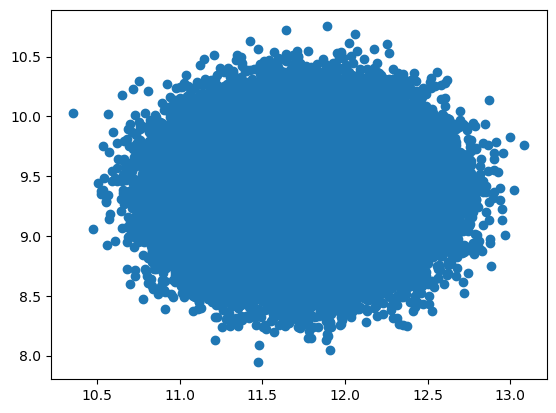

In [12]:
# Plotting the dataset-

plt.scatter(X_train[:,0], X_train[:,1])
plt.show()

In [13]:
# Defining the model and fitting and predicting based on it-

iforest = IsolationForest(n_estimators = 200, contamination=.02)
pred = iforest.fit_predict(X_train)


In [14]:
# Extracting the negative outputs as the outliers-

anom_index = where(pred == -1)
values = X_train[anom_index]

In [16]:
# Printing the results-

print("Number of outliers detected: {}".format(-pred[pred < 0].sum()))
print("Number of normal samples detected: {}".format(pred[pred > 0].sum()))

Number of outliers detected: 5000
Number of normal samples detected: 245000


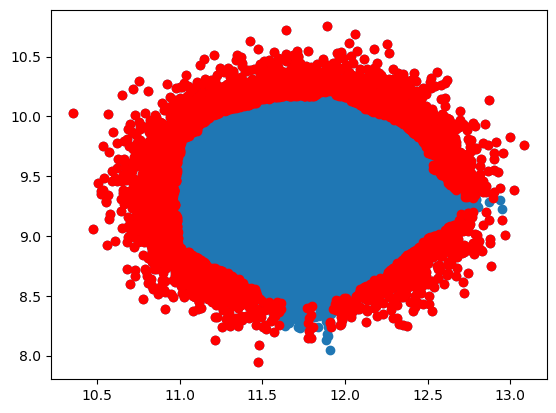

In [17]:
# Visualizing the results in a plot by highlighting the anomalies with red color-

plt.scatter(X_train[:,0], X_train[:,1])
plt.scatter(values[:,0], values[:,1], color='r')
plt.show()

The plot above highlights the outliers based on the model defined. But the count of outliers is far too much, and it doesn't look like a good anomaly prediction.

#### **Model 2- Anomaly detection with Isolation Forest with scores**

In [18]:
# Defining the model without setting the contamination argument-

iforest_s = IsolationForest(n_estimators=100)

In [19]:
# Fitting the model with training dataset, and extracting the samples scores-

iforest_s.fit(X_train)
scores = iforest_s.score_samples(X_train)

**Lowest 1% as Anomalies-**

In [24]:
# Obtaining the threshold value from the scores by using the quantile function.
# Defining the lowest 1% as anomalies-

thresh_1 = quantile(scores, .01)
print(thresh_1)

-0.652994665997297


In [25]:
# Extracting the anomalies by comparing the threshold value and getting values from the indexes-

index_1 = where(scores <= thresh_1)
values_1 = X_train[index_1]

In [28]:
# Printing the results-

print(values_1.shape)

(2500, 2)


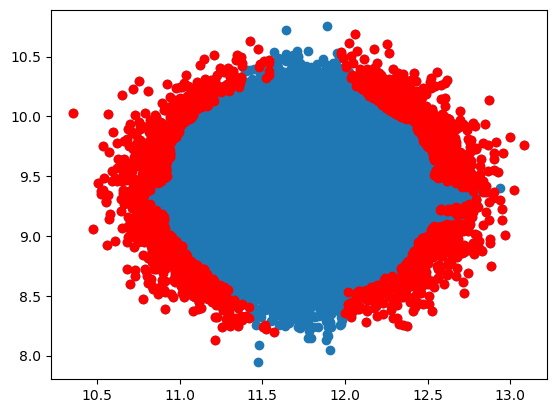

In [30]:
# Visualizing the results in a plot by highlighting the anomalies with red color-

plt.scatter(X_train[:,0], X_train[:,1])
plt.scatter(values_1[:,0], values_1[:,1], color='r')
plt.show()

The above plot looks better than the previous plots, but the anomalies still look a lot more than they should be. The model isn't great in my opinion.

#### **Model 3- Anomaly Detection with One-Class SVM**
**(Hyperparameters- kernel='rbf', gamma=0.001, nu=0.01)**

In [31]:
# Importing the necessary library-

from sklearn.svm import OneClassSVM

In [32]:
# Creating a random sample dataset by using the make_blob() function-

random.seed(3)
X_train, _ = make_blobs(n_samples=250000, centers=1, cluster_std=.3, center_box=(8, 8))

In [33]:
# Defining the SVM model-

svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.01)

In [34]:
# Fitting and predicting using SVM model-

svm.fit(X_train)
pred_svm = svm.predict(X_train)

In [35]:
# Extracting the negative outputs as the outliers-

anom_index_svm = where(pred_svm == -1)
values_svm = X_train[anom_index_svm]

In [36]:
# Printing the results-

print(values_svm.shape)
print("Number of outliers detected: {}".format(-pred_svm[pred_svm < 0].sum()))
print("Number of normal samples detected: {}".format(pred_svm[pred_svm > 0].sum()))

(2499, 2)
Number of outliers detected: 2499
Number of normal samples detected: 247501


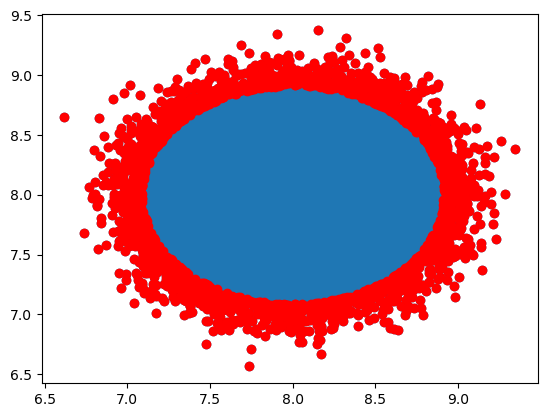

In [118]:
# Visualizing the results in a plot by highlighting the anomalies with red color-

plt.scatter(X_train[:,0], X_train[:,1])
plt.scatter(values_svm[:,0], values_svm[:,1], color='r')
plt.show()

The above plot is uniform in terms of anomalies, but it could be improved by managing the hyperparameters of the model.

#### **Model 4- Anomaly Detection with One-Class SVM**
**(Hyperparameters- kernel= 'rbf', gamma= 'auto', nu= 0.01)**

In [124]:
# Defining the SVM model with different parameters-

svm_3 = OneClassSVM(kernel='rbf', gamma= 'auto', nu=0.001)

In [125]:
# Fitting and predicting using the new SVM model-

svm_3.fit(X_train)
pred_svm_3 = svm_3.predict(X_train)

In [126]:
# Extracting the negative outputs as the outliers-

anom_index_svm_3 = where(pred_svm_3 == -1)
values_svm_3 = X_train[anom_index_svm_3]

In [127]:
# Printing the results-

print(values_svm_3.shape)
print("Number of outliers detected: {}".format(-pred_svm_3[pred_svm_3 < 0].sum()))
print("Number of normal samples detected: {}".format(pred_svm_3[pred_svm_3 > 0].sum()))

(252, 2)
Number of outliers detected: 252
Number of normal samples detected: 249748


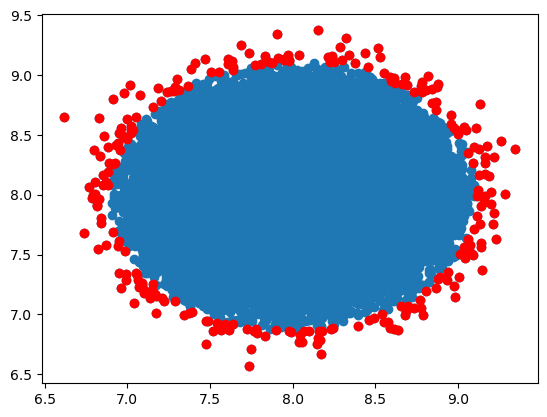

In [128]:
# Visualizing the results in a plot by highlighting the anomalies with red color-

plt.scatter(X_train[:,0], X_train[:,1])
plt.scatter(values_svm_3[:,0], values_svm_3[:,1], color='r')
plt.show()

This plot and model seems to be the best among the different models I have created and I'll use this in my test dataset to check the results.

### **Predicting Anomalies for the test data using the 4th model (One-Class SVM)-**

In [37]:
# Dropping time column from the data-

X_test = X_test.drop('_time', axis=1)

In [130]:
# Creating a random sample dataset by using the make_blob() function-

random.seed(3)
X_test, _ = make_blobs(n_samples=70000, centers=1, cluster_std=.3, center_box=(8, 8))

In [131]:
# Applying the model-

pred_svm_test = svm_3.predict(X_test)

In [132]:
# Extracting the negative outputs as the outliers-

anom_index_svm_test = where(pred_svm_test == -1)
values_svm_test = X_test[anom_index_svm_test]

In [133]:
# Printing the results-

print(values_svm_test.shape)
print("Number of outliers detected: {}".format(-pred_svm_test[pred_svm_test < 0].sum()))
print("Number of normal samples detected: {}".format(pred_svm_test[pred_svm_test > 0].sum()))

(71, 2)
Number of outliers detected: 71
Number of normal samples detected: 69929


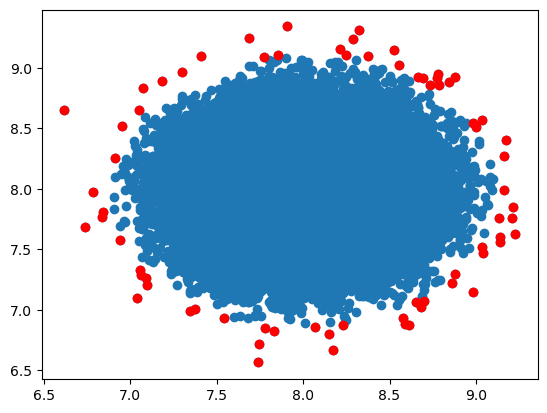

In [134]:
# Visualizing the results in a plot by highlighting the anomalies with red color-

plt.scatter(X_test[:,0], X_test[:,1])
plt.scatter(values_svm_test[:,0], values_svm_test[:,1], color='r')
plt.show()

#### **Interpretation of the Results**

After predicting the anomalies using IsolationForest and One-Class SVM, I created scatterplots of the results to easily identify the best performing model. Since my data was not labeled and this is an unsupervised model, I could not rely on the accuracy to find the best model. I instead relied on the visualization to see the anomalies.
The plots allowed me to visually inspect the performance of both the models and their variations with different parameters in detecting outliers.

I created 4 models- 2 for Isolation Forest and 2 for One-Class SVM, with combinations of hyperparameters. The Isolation Forest didn't givce me satisfactory results, however One-Class SVM performed bettter. I found that the 4th model of One-Class SVM with kernel='rbf', gamma= 'auto', nu=0.001 performed best, based on the visualization of anomalies in the training and test datasets.

Hyperparameters I defined in the best One-class SVM model:

-	nu: This is a crucial hyperparameter in One-Class SVM, which controls the proportion of outliers allowed. I kept it as 0.001 as I wanted the outliers to be in 0.1% range.
-	kernel: The kernel function determines the type of decision boundary the SVM uses. I used ‘rbf’ kernel as it can effectively capture complex non-linear relationships.
-	gamma: This is a parameter for non-linear hyperplanes. This parameter is specific to the RBF kernel and I set it to ‘auto,’ which defaults to 1 / n_features.

#### **Conclusion/ Recommendation**

I finally used One-Class Support Vector Machine (SVM), which is a variant of the traditional SVM. It is specifically tailored to detect anomalies. Its primary aim is to locate instances that notably deviate from the standard. Unlike conventional Machine Learning models focused on binary or multiclass classification, the one-class SVM specializes in outlier or novelty detection within datasets.

I would recommend building a One-Class SVM model for anomaly detection and define alerts, so that an alert is triggerred whenever an anomaly is detected in the data, so that the anomaly could be further investigated, and corrective actions taken.